# Data Ingest

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as tfhub

import matplotlib.pyplot as plt

In [2]:
TRAIN_DIR = '/kaggle/input/landscape-recognition-image-dataset-12k-images/Landscape Classification/Landscape Classification/Training Data'

IMG_SIZE = (224,224)
CLASS_LABELS = ["Coast", "Desert", "Forest", "Glacier", "Mountain"]
BATCH_SIZE = 32
TF_RANDOM_SEED = 42

def make_data_gen(dir_location):
    data_gen = tf.keras.preprocessing.image.ImageDataGenerator()
    return data_gen.flow_from_directory(dir_location,
                                              target_size=IMG_SIZE,
                                              classes=CLASS_LABELS,
                                              class_mode='sparse',
                                              seed=TF_RANDOM_SEED)
train_data = make_data_gen(TRAIN_DIR)

Found 10000 images belonging to 5 classes.


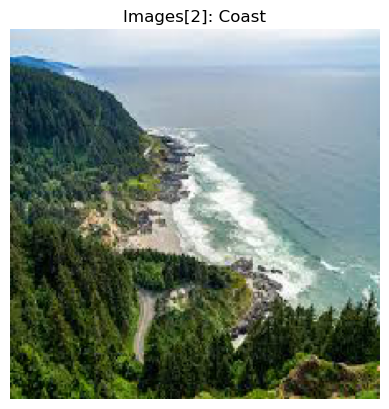

In [3]:
def show_random_image(dir_iter):
    batch_index = 0
    img_index = np.random.randint(32)
    label = CLASS_LABELS[int(dir_iter[batch_index][1][img_index])]

    plt.imshow(dir_iter[batch_index][0][img_index]/255.0)
    plt.title(f"Images[{img_index}]: {label}")
    plt.axis("off")
    plt.show()

show_random_image(train_data)

Found 1500 images belonging to 5 classes.


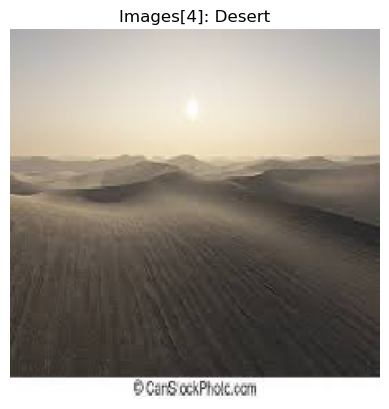

In [4]:
VALID_DIR = '/kaggle/input/landscape-recognition-image-dataset-12k-images/Landscape Classification/Landscape Classification/Validation Data'

valid_data = make_data_gen(VALID_DIR)
show_random_image(valid_data)

Found 500 images belonging to 5 classes.


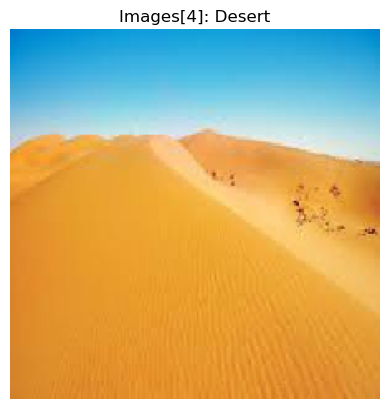

In [5]:
TEST_DIR = '/kaggle/input/landscape-recognition-image-dataset-12k-images/Landscape Classification/Landscape Classification/Testing Data'

test_data = make_data_gen(TEST_DIR)
show_random_image(test_data)

# Model 1A - Efficient Nets with Feature Extraction

In [6]:
EPOCHS = 5

tf.random.set_seed(TF_RANDOM_SEED)

inputs = tf.keras.layers.Input(shape=IMG_SIZE + (3,))

basenet_model = tf.keras.applications.EfficientNetB0(include_top=False)
basenet_model.trainable = False
basenet_model = basenet_model(inputs)

outputs = tf.keras.layers.GlobalAveragePooling2D()(basenet_model)
outputs = tf.keras.layers.Dense(len(CLASS_LABELS), activation="softmax")(outputs)

effnet_model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [7]:
def train_model(model, callbacks=[]):
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    return model.fit(train_data, 
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE,
                     steps_per_epoch=len(train_data),
                     validation_data=valid_data, 
                     validation_steps=int(0.25 * len(valid_data)),
                     callbacks=callbacks)

In [8]:
effnet_history = train_model(effnet_model)

Epoch 1/5
313/313 [==============================] - 74s 201ms/step - loss: 0.5498 - accuracy: 0.8214 - val_loss: 0.4926 - val_accuracy: 0.8324
Epoch 2/5
313/313 [==============================] - 27s 87ms/step - loss: 0.3552 - accuracy: 0.8825 - val_loss: 0.6063 - val_accuracy: 0.7869
Epoch 3/5
313/313 [==============================] - 27s 87ms/step - loss: 0.3219 - accuracy: 0.8931 - val_loss: 0.5121 - val_accuracy: 0.8097
Epoch 4/5
313/313 [==============================] - 27s 85ms/step - loss: 0.2941 - accuracy: 0.8995 - val_loss: 0.5137 - val_accuracy: 0.8267
Epoch 5/5
313/313 [==============================] - 29s 92ms/step - loss: 0.2824 - accuracy: 0.9050 - val_loss: 0.4638 - val_accuracy: 0.8352


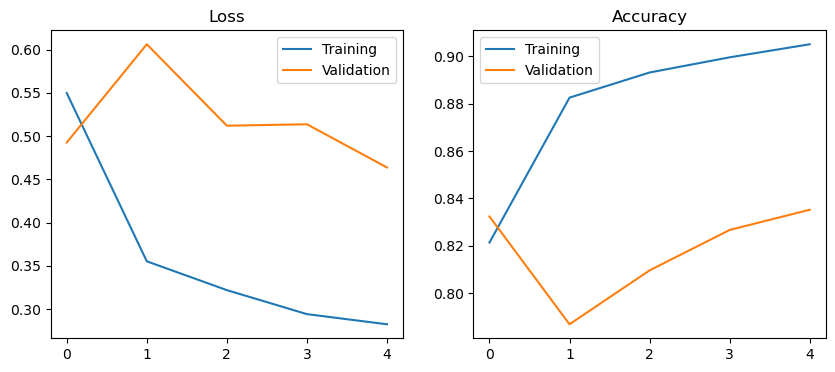

In [9]:
def plot_history(history):
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.plot(history.history['loss'], label="Training")
    plt.plot(history.history['val_loss'], label="Validation")
    plt.title("Loss")
    plt.legend()
    
    plt.subplot(122)
    plt.plot(history.history['accuracy'], label="Training")
    plt.plot(history.history['val_accuracy'], label="Validation")
    plt.title("Accuracy")
    
    plt.legend()
    plt.show()
    
plot_history(effnet_history)

In [10]:
def evaluate_model(model):
    metrics = model.evaluate(test_data)
    print(f"Accuracy: {metrics[1] * 100:.2f}%")

evaluate_model(effnet_model)

16/16 [==============================] - 3s 201ms/step - loss: 0.2713 - accuracy: 0.8940
Accuracy: 89.40%


# Model 1B - EfficientNet with Data Augmentation


In [11]:
augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
], name="augmentation_layers")

In [12]:
model1b_checkpoint_filepath = "model1b/best_model.ckpt"
model1b_checkpoint = tf.keras.callbacks.ModelCheckpoint(model1b_checkpoint_filepath,
                                                        monitor='val_accuracy',
                                                        save_best_only=True,
                                                        save_weights_only=False)

In [13]:
tf.random.set_seed(TF_RANDOM_SEED)
inputs = tf.keras.layers.Input(shape=IMG_SIZE + (3,))
model_chain = augmentation_layers(inputs)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

model_chain = base_model(model_chain)
model_chain = tf.keras.layers.GlobalAveragePooling2D()(model_chain)
output_layer = tf.keras.layers.Dense(len(CLASS_LABELS), activation="softmax")(model_chain)


model1b = tf.keras.Model(inputs, output_layer)
model1b.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 augmentation_layers (Sequen  (None, 224, 224, 3)      0         
 tial)                                                           
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 6,405
Non-trainab

In [14]:
model1b_history = train_model(model1b, [model1b_checkpoint])

Epoch 1/5
313/313 [==============================] - 80s 236ms/step - loss: 0.7355 - accuracy: 0.7370 - val_loss: 0.6400 - val_accuracy: 0.7727
Epoch 2/5
313/313 [==============================] - 72s 231ms/step - loss: 0.5402 - accuracy: 0.8056 - val_loss: 0.5897 - val_accuracy: 0.8011
Epoch 3/5
313/313 [==============================] - 32s 102ms/step - loss: 0.4932 - accuracy: 0.8223 - val_loss: 0.5886 - val_accuracy: 0.7784
Epoch 4/5
313/313 [==============================] - 32s 103ms/step - loss: 0.4791 - accuracy: 0.8313 - val_loss: 0.5664 - val_accuracy: 0.7898
Epoch 5/5
313/313 [==============================] - 73s 234ms/step - loss: 0.4635 - accuracy: 0.8357 - val_loss: 0.5359 - val_accuracy: 0.8182


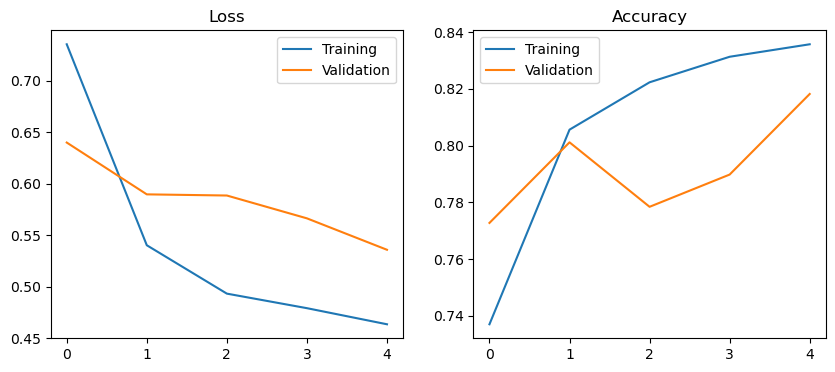

In [15]:
plot_history(model1b_history)

In [16]:
evaluate_model(model1b)

16/16 [==============================] - 2s 100ms/step - loss: 0.3738 - accuracy: 0.8500
Accuracy: 85.00%


# Model 1C - Fine-tuning layers

In [17]:
model1c = tf.keras.models.load_model(model1b_checkpoint_filepath)
model1c.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 augmentation_layers (Sequen  (None, 224, 224, 3)      0         
 tial)                                                           
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 6,405
Non-trainab

In [18]:
evaluate_model(model1c)

16/16 [==============================] - 3s 92ms/step - loss: 0.3738 - accuracy: 0.8500
Accuracy: 85.00%


In [19]:
for i, layer in enumerate(model1c.layers):
    print(f"{i} {layer.name}: {layer.trainable}")

0 input_3: True
1 augmentation_layers: True
2 efficientnetb0: False
3 global_average_pooling2d_1: True
4 dense_1: True


In [20]:
tf.random.set_seed(TF_RANDOM_SEED)

model1c.layers[2].trainable = True
for i, layer in enumerate(model1c.layers[2].layers):
    layer.trainable = (i >= 227)
    
for i, layer in enumerate(model1c.layers[2].layers):
    print(f"{i} {layer.name}: {layer.trainable}")

0 input_4: False
1 rescaling_1: False
2 normalization_1: False
3 tf.math.truediv_1: False
4 stem_conv_pad: False
5 stem_conv: False
6 stem_bn: False
7 stem_activation: False
8 block1a_dwconv: False
9 block1a_bn: False
10 block1a_activation: False
11 block1a_se_squeeze: False
12 block1a_se_reshape: False
13 block1a_se_reduce: False
14 block1a_se_expand: False
15 block1a_se_excite: False
16 block1a_project_conv: False
17 block1a_project_bn: False
18 block2a_expand_conv: False
19 block2a_expand_bn: False
20 block2a_expand_activation: False
21 block2a_dwconv_pad: False
22 block2a_dwconv: False
23 block2a_bn: False
24 block2a_activation: False
25 block2a_se_squeeze: False
26 block2a_se_reshape: False
27 block2a_se_reduce: False
28 block2a_se_expand: False
29 block2a_se_excite: False
30 block2a_project_conv: False
31 block2a_project_bn: False
32 block2b_expand_conv: False
33 block2b_expand_bn: False
34 block2b_expand_activation: False
35 block2b_dwconv: False
36 block2b_bn: False
37 block2b_

In [21]:
model1c.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"]
)

model1c_history = model1c.fit(train_data,
                            epochs=EPOCHS + 5,
                            batch_size=BATCH_SIZE,
                            steps_per_epoch=len(train_data),
                            validation_data=valid_data,
                            validation_steps=int(0.25 * len(valid_data)),
                            initial_epoch=5)

Epoch 6/10
313/313 [==============================] - 43s 113ms/step - loss: 0.4716 - accuracy: 0.8297 - val_loss: 0.6419 - val_accuracy: 0.7869
Epoch 7/10
313/313 [==============================] - 32s 103ms/step - loss: 0.4164 - accuracy: 0.8478 - val_loss: 0.5490 - val_accuracy: 0.8182
Epoch 8/10
313/313 [==============================] - 32s 101ms/step - loss: 0.3867 - accuracy: 0.8626 - val_loss: 0.5354 - val_accuracy: 0.8239
Epoch 9/10
313/313 [==============================] - 32s 102ms/step - loss: 0.3590 - accuracy: 0.8751 - val_loss: 0.4618 - val_accuracy: 0.8494
Epoch 10/10
313/313 [==============================] - 32s 102ms/step - loss: 0.3369 - accuracy: 0.8814 - val_loss: 0.4867 - val_accuracy: 0.8551


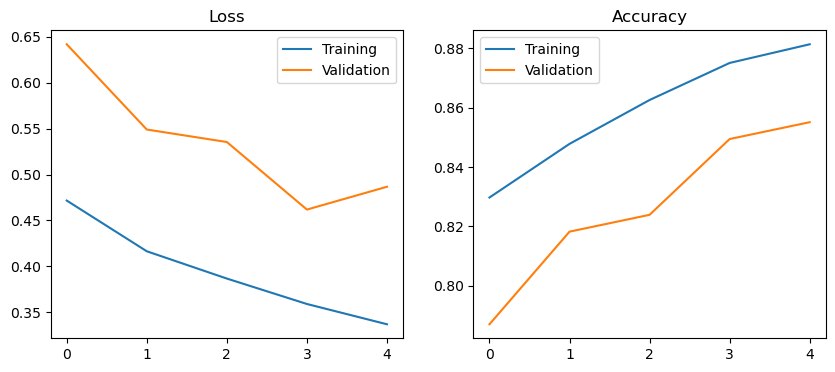

[5, 6, 7, 8, 9]

In [22]:
plot_history(model1c_history)
model1c_history.epoch

In [23]:
def plot_fine_tune_history(pre_history, post_history):
    fig, axs = plt.subplots( 1, 2,figsize=(10, 4))
    axs[0].plot(pre_history.epoch + post_history.epoch, 
            pre_history.history["loss"] + post_history.history["loss"],
            label="Training")
    axs[0].plot(pre_history.epoch + post_history.epoch, 
            pre_history.history["val_loss"] + post_history.history["val_loss"],
            label="Validation")
    axs[0].axvline(len(pre_history.epoch) - 1, 0, 1, color="red", linestyle="--")
    axs[0].set_title("Loss")
    axs[0].legend()
    
    axs[1].plot(pre_history.epoch + post_history.epoch, 
            pre_history.history["accuracy"] + post_history.history["accuracy"],
            label="Training")
    axs[1].plot(pre_history.epoch + post_history.epoch, 
            pre_history.history["val_accuracy"] + post_history.history["val_accuracy"],
            label="Validation")
    axs[1].axvline(len(pre_history.epoch) - 1, 0, 1, color="red", linestyle="--")
    axs[1].set_title("Accuracy")
    axs[1].legend()
    
    plt.show()

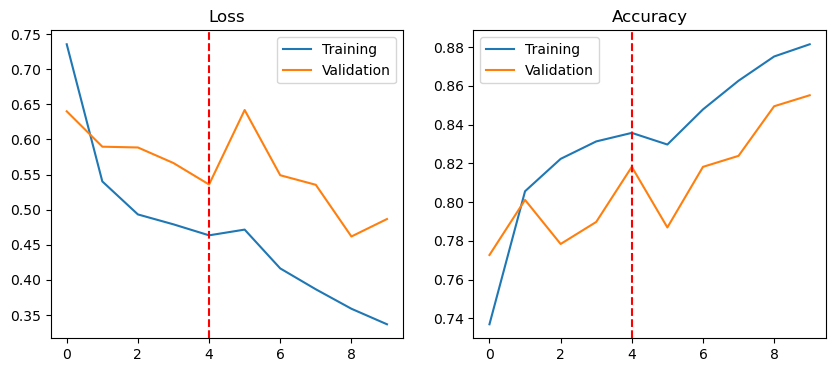

In [24]:
plot_fine_tune_history(model1b_history, model1c_history)

In [25]:
model1b_history.history["loss"]

[0.7354623079299927,
 0.540245771408081,
 0.4932490289211273,
 0.47912198305130005,
 0.46348047256469727]

In [26]:
evaluate_model(model1c)

16/16 [==============================] - 1s 89ms/step - loss: 0.3164 - accuracy: 0.8780
Accuracy: 87.80%


# Model 2A - ResNet with Feature Extraction

In [27]:
tf.random.set_seed(TF_RANDOM_SEED)

inputs = tf.keras.layers.Input(shape=IMG_SIZE+(3,))

model_chain = tf.keras.layers.Rescaling(1./255)(inputs)

base_model = tf.keras.applications.ResNet50(include_top=False)
base_model.activity_regularizertrainable = False
model_chain = base_model(model_chain)

model_chain = tf.keras.layers.GlobalAveragePooling2D()(model_chain)
model_chain = tf.keras.layers.Dense(len(CLASS_LABELS), activation="softmax")(model_chain)

model2a = tf.keras.models.Model(inputs, model_chain)

94765736/94765736 [==============================] - 1s 0us/step


In [28]:
model2a_history = train_model(model2a)

Epoch 1/5
313/313 [==============================] - 65s 187ms/step - loss: 0.8516 - accuracy: 0.7107 - val_loss: 4.1465 - val_accuracy: 0.1847
Epoch 2/5
313/313 [==============================] - 57s 183ms/step - loss: 0.5938 - accuracy: 0.7963 - val_loss: 2.0147 - val_accuracy: 0.2131
Epoch 3/5
313/313 [==============================] - 57s 183ms/step - loss: 0.4974 - accuracy: 0.8309 - val_loss: 0.9070 - val_accuracy: 0.6250
Epoch 4/5
313/313 [==============================] - 58s 184ms/step - loss: 0.5141 - accuracy: 0.8207 - val_loss: 2.0661 - val_accuracy: 0.5341
Epoch 5/5
313/313 [==============================] - 58s 184ms/step - loss: 0.4159 - accuracy: 0.8596 - val_loss: 0.6895 - val_accuracy: 0.7756


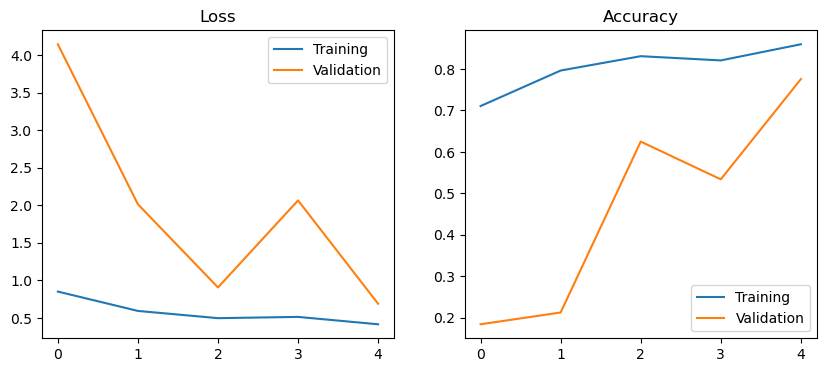

In [29]:
plot_history(model2a_history)

In [30]:
evaluate_model(model2a)

16/16 [==============================] - 2s 98ms/step - loss: 0.5243 - accuracy: 0.7960
Accuracy: 79.60%


# Model 2B - Resnet Model with Data Augmentation Layers

In [31]:
tf.random.set_seed(TF_RANDOM_SEED)

data_augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

In [32]:
inputs = tf.keras.layers.Input(shape=IMG_SIZE + (3,))
model_chain = augmentation_layers(inputs)
model_chain = tf.keras.layers.Rescaling(1./255)(model_chain)

base_model = tf.keras.applications.ResNet50(include_top=False)
base_model.trainable = False
model_chain = base_model(model_chain)

model_chain = tf.keras.layers.GlobalAveragePooling2D()(model_chain)
model_chain = tf.keras.layers.Dense(len(CLASS_LABELS), activation="softmax")(model_chain)
model2b = tf.keras.Model(inputs,  model_chain)

In [33]:
model2b_checkpoint_filepath = "model2b/best_model.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model2b_checkpoint_filepath,
                                                      monitor='val_accuracy',
                                                      save_best_only=True,
                                                      save_weights_only=False)
model2b_history = train_model(model2b, [model_checkpoint])

Epoch 1/5
313/313 [==============================] - 61s 186ms/step - loss: 1.5790 - accuracy: 0.2638 - val_loss: 1.5170 - val_accuracy: 0.2955
Epoch 2/5
313/313 [==============================] - 33s 107ms/step - loss: 1.5342 - accuracy: 0.3198 - val_loss: 1.5787 - val_accuracy: 0.2670
Epoch 3/5
313/313 [==============================] - 56s 178ms/step - loss: 1.5073 - accuracy: 0.3427 - val_loss: 1.4792 - val_accuracy: 0.3693
Epoch 4/5
313/313 [==============================] - 58s 184ms/step - loss: 1.4937 - accuracy: 0.3432 - val_loss: 1.4792 - val_accuracy: 0.3750
Epoch 5/5
313/313 [==============================] - 34s 108ms/step - loss: 1.4850 - accuracy: 0.3522 - val_loss: 1.4988 - val_accuracy: 0.3409


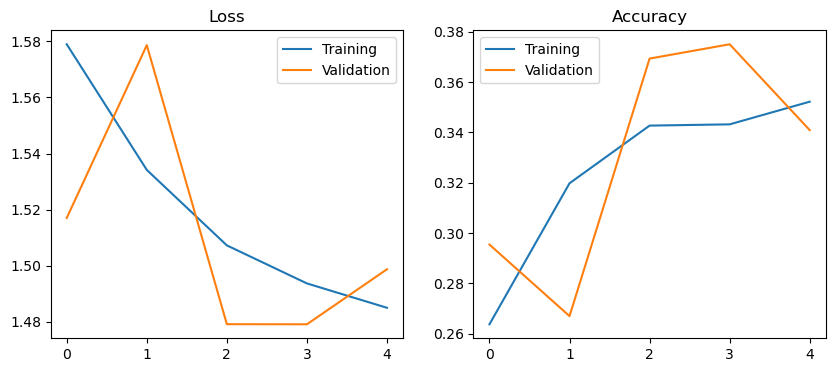

In [34]:
plot_history(model2b_history)

In [35]:
evaluate_model(model2b)

16/16 [==============================] - 2s 89ms/step - loss: 1.4638 - accuracy: 0.3560
Accuracy: 35.60%


# Model 3C - Resnet Model with Fine-Tuning

In [36]:
model2c = tf.keras.models.load_model(model2b_checkpoint_filepath)
evaluate_model(model2c)

16/16 [==============================] - 3s 84ms/step - loss: 1.4741 - accuracy: 0.3780
Accuracy: 37.80%


In [37]:
model2c.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 augmentation_layers (Sequen  (None, 224, 224, 3)      0         
 tial)                                                           
                                                                 
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 5)                 1024

In [38]:
for idx, layer in enumerate(model2c.layers):
    print(f"{idx} {layer.name}: {layer.trainable}")

0 input_7: True
1 augmentation_layers: True
2 rescaling_3: True
3 resnet50: False
4 global_average_pooling2d_3: True
5 dense_3: True


In [39]:
model2c.layers[3].trainable=True

for layer in model2c.layers[3].layers[:165]:
    layer.trainable = False

for layer in model2c.layers[3].layers[165:]:
    layer.trainable = True

In [40]:
for idx, layer in enumerate(model2c.layers[3].layers):
    print(f"{idx} {layer.name}: {layer.trainable}")

0 input_8: False
1 conv1_pad: False
2 conv1_conv: False
3 conv1_bn: False
4 conv1_relu: False
5 pool1_pad: False
6 pool1_pool: False
7 conv2_block1_1_conv: False
8 conv2_block1_1_bn: False
9 conv2_block1_1_relu: False
10 conv2_block1_2_conv: False
11 conv2_block1_2_bn: False
12 conv2_block1_2_relu: False
13 conv2_block1_0_conv: False
14 conv2_block1_3_conv: False
15 conv2_block1_0_bn: False
16 conv2_block1_3_bn: False
17 conv2_block1_add: False
18 conv2_block1_out: False
19 conv2_block2_1_conv: False
20 conv2_block2_1_bn: False
21 conv2_block2_1_relu: False
22 conv2_block2_2_conv: False
23 conv2_block2_2_bn: False
24 conv2_block2_2_relu: False
25 conv2_block2_3_conv: False
26 conv2_block2_3_bn: False
27 conv2_block2_add: False
28 conv2_block2_out: False
29 conv2_block3_1_conv: False
30 conv2_block3_1_bn: False
31 conv2_block3_1_relu: False
32 conv2_block3_2_conv: False
33 conv2_block3_2_bn: False
34 conv2_block3_2_relu: False
35 conv2_block3_3_conv: False
36 conv2_block3_3_bn: False
37

In [41]:
model2c.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"]
)

model2c_history = model2c.fit(train_data,
                                epochs=EPOCHS+5,
                                steps_per_epoch=len(train_data),
                                validation_data=valid_data,
                                validation_steps=len(valid_data),
                                initial_epoch=5)

Epoch 6/10
313/313 [==============================] - 42s 121ms/step - loss: 1.3006 - accuracy: 0.4504 - val_loss: 1.5273 - val_accuracy: 0.3740
Epoch 7/10
313/313 [==============================] - 38s 120ms/step - loss: 1.1669 - accuracy: 0.5126 - val_loss: 1.7962 - val_accuracy: 0.3853
Epoch 8/10
313/313 [==============================] - 39s 124ms/step - loss: 1.1150 - accuracy: 0.5407 - val_loss: 1.9574 - val_accuracy: 0.3887
Epoch 9/10
313/313 [==============================] - 36s 116ms/step - loss: 1.0838 - accuracy: 0.5570 - val_loss: 2.9884 - val_accuracy: 0.2747
Epoch 10/10
313/313 [==============================] - 37s 118ms/step - loss: 1.0568 - accuracy: 0.5676 - val_loss: 4.4069 - val_accuracy: 0.2787


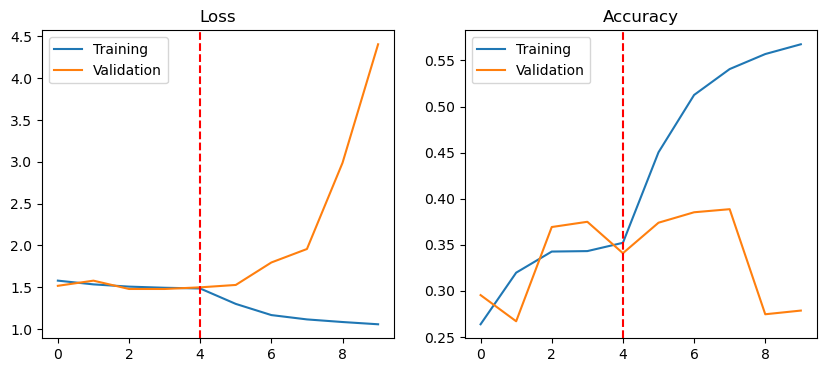

In [42]:
plot_fine_tune_history(model2b_history, model2c_history)

In [43]:
evaluate_model(model2c)

16/16 [==============================] - 2s 98ms/step - loss: 4.2354 - accuracy: 0.2760
Accuracy: 27.60%


# Model 3A - Inception Model with Feature Extraction

In [44]:
tf.random.set_seed(TF_RANDOM_SEED)

base_model = tf.keras.applications.InceptionV3(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=IMG_SIZE + (3,))
model_chain = tf.keras.layers.Rescaling(1./255)(inputs)
model_chain = base_model(model_chain)
model_chain = tf.keras.layers.GlobalAveragePooling2D()(model_chain)
model_chain = tf.keras.layers.Dense(len(CLASS_LABELS), activation="softmax")(model_chain)

model3a = tf.keras.Model(inputs, model_chain)

87910968/87910968 [==============================] - 1s 0us/step


In [45]:
model3a_history = train_model(model3a)

Epoch 1/5
313/313 [==============================] - 38s 101ms/step - loss: 0.6376 - accuracy: 0.7704 - val_loss: 0.5097 - val_accuracy: 0.8153
Epoch 2/5
313/313 [==============================] - 28s 89ms/step - loss: 0.4633 - accuracy: 0.8370 - val_loss: 0.5916 - val_accuracy: 0.7898
Epoch 3/5
313/313 [==============================] - 28s 90ms/step - loss: 0.4126 - accuracy: 0.8573 - val_loss: 0.4846 - val_accuracy: 0.8551
Epoch 4/5
313/313 [==============================] - 28s 89ms/step - loss: 0.3882 - accuracy: 0.8637 - val_loss: 0.6772 - val_accuracy: 0.7812
Epoch 5/5
313/313 [==============================] - 30s 97ms/step - loss: 0.3651 - accuracy: 0.8772 - val_loss: 0.5694 - val_accuracy: 0.7955


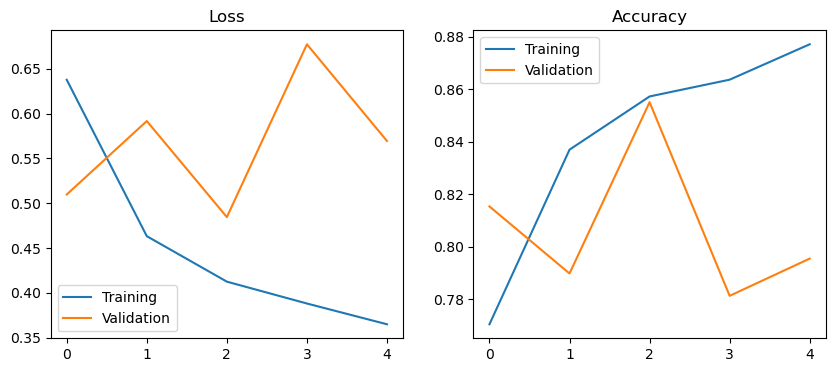

In [46]:
plot_history(model3a_history)

In [47]:
evaluate_model(model3a)

16/16 [==============================] - 2s 94ms/step - loss: 0.4044 - accuracy: 0.8600
Accuracy: 86.00%


# Model 3B - Inception Model with Data Augmentation

In [48]:
tf.random.set_seed(TF_RANDOM_SEED)

augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

base_model = tf.keras.applications.InceptionV3(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=IMG_SIZE + (3,))
model_chain = augmentation_layers(inputs)
model_chain = tf.keras.layers.Rescaling(1./255)(model_chain)
model_chain = base_model(model_chain)
model_chain = tf.keras.layers.GlobalAveragePooling2D()(model_chain)
model_chain = tf.keras.layers.Dense(len(CLASS_LABELS), activation="softmax")(model_chain)
model3b = tf.keras.Model(inputs, model_chain)

In [49]:
model3b_checkpoint_filepath = "model3b/best_model.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model3b_checkpoint_filepath, 
                                                      monitor='val_accuracy',
                                                      save_best_only=True,
                                                      save_weights_only=False)

model3b_history = train_model(model3b, [model_checkpoint])

Epoch 1/5
313/313 [==============================] - 72s 216ms/step - loss: 0.8830 - accuracy: 0.6718 - val_loss: 0.6903 - val_accuracy: 0.7528
Epoch 2/5
313/313 [==============================] - 34s 109ms/step - loss: 0.6911 - accuracy: 0.7466 - val_loss: 0.6697 - val_accuracy: 0.7472
Epoch 3/5
313/313 [==============================] - 68s 218ms/step - loss: 0.6422 - accuracy: 0.7626 - val_loss: 0.6589 - val_accuracy: 0.7614
Epoch 4/5
313/313 [==============================] - 33s 104ms/step - loss: 0.6224 - accuracy: 0.7731 - val_loss: 0.8244 - val_accuracy: 0.6790
Epoch 5/5
313/313 [==============================] - 33s 104ms/step - loss: 0.6249 - accuracy: 0.7703 - val_loss: 0.7819 - val_accuracy: 0.7159


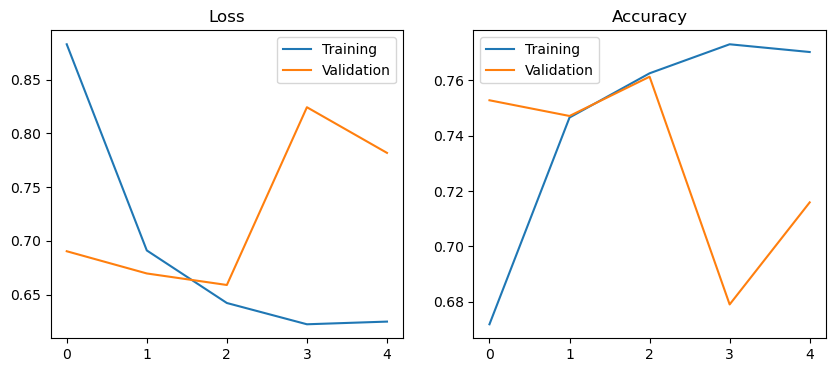

In [50]:
plot_history(model3b_history)

In [51]:
evaluate_model(model3b)

16/16 [==============================] - 2s 91ms/step - loss: 0.4888 - accuracy: 0.8200
Accuracy: 82.00%


# Model 3C - Inception Model with Fine - Tuning

In [52]:
model3c = tf.keras.models.load_model(model3b_checkpoint_filepath)
evaluate_model(model3c)

16/16 [==============================] - 3s 107ms/step - loss: 0.5245 - accuracy: 0.8100
Accuracy: 81.00%


In [53]:
# What are the layers?
for index, layer in enumerate(model3c.layers):
    print(f"{index} {layer.name}: {layer.trainable}")

0 input_12: True
1 sequential_1: True
2 rescaling_5: True
3 inception_v3: False
4 global_average_pooling2d_5: True
5 dense_5: True


In [54]:
model3c.layers[3].trainable = True
for layer in model3c.layers[3].layers[:-10]:
    layer.trainable = False

for index, layer in enumerate(model3c.layers[3].layers):
    print(f"{index} {layer.name}: {layer.trainable}")

0 input_11: False
1 conv2d_94: False
2 batch_normalization_94: False
3 activation_94: False
4 conv2d_95: False
5 batch_normalization_95: False
6 activation_95: False
7 conv2d_96: False
8 batch_normalization_96: False
9 activation_96: False
10 max_pooling2d_4: False
11 conv2d_97: False
12 batch_normalization_97: False
13 activation_97: False
14 conv2d_98: False
15 batch_normalization_98: False
16 activation_98: False
17 max_pooling2d_5: False
18 conv2d_102: False
19 batch_normalization_102: False
20 activation_102: False
21 conv2d_100: False
22 conv2d_103: False
23 batch_normalization_100: False
24 batch_normalization_103: False
25 activation_100: False
26 activation_103: False
27 average_pooling2d_9: False
28 conv2d_99: False
29 conv2d_101: False
30 conv2d_104: False
31 conv2d_105: False
32 batch_normalization_99: False
33 batch_normalization_101: False
34 batch_normalization_104: False
35 batch_normalization_105: False
36 activation_99: False
37 activation_101: False
38 activation_104

In [55]:
model3c.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"]
)

model3c_history = model3c.fit(train_data,
                             epochs=EPOCHS + 5,
                             steps_per_epoch=len(train_data),
                             validation_data=valid_data,
                             validation_steps=len(valid_data),
                             initial_epoch=5)

Epoch 6/10
313/313 [==============================] - 43s 123ms/step - loss: 0.6014 - accuracy: 0.7759 - val_loss: 0.6476 - val_accuracy: 0.7713
Epoch 7/10
313/313 [==============================] - 37s 117ms/step - loss: 0.5984 - accuracy: 0.7826 - val_loss: 0.6365 - val_accuracy: 0.7740
Epoch 8/10
313/313 [==============================] - 36s 114ms/step - loss: 0.5884 - accuracy: 0.7868 - val_loss: 0.6383 - val_accuracy: 0.7720
Epoch 9/10
313/313 [==============================] - 37s 117ms/step - loss: 0.5730 - accuracy: 0.7929 - val_loss: 0.6456 - val_accuracy: 0.7727
Epoch 10/10
313/313 [==============================] - 38s 120ms/step - loss: 0.5852 - accuracy: 0.7838 - val_loss: 0.6401 - val_accuracy: 0.7660


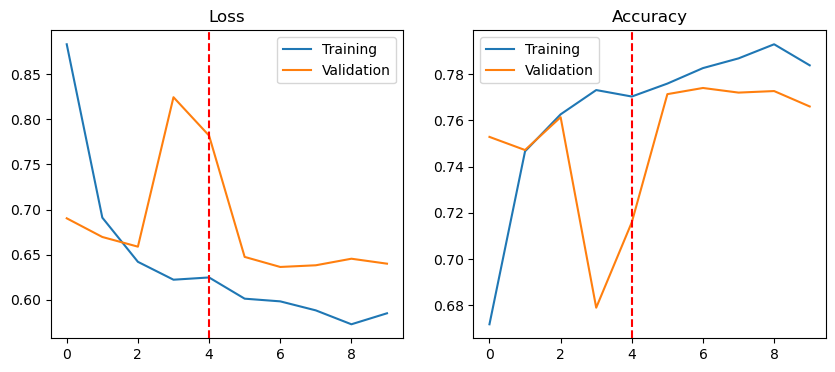

In [56]:
plot_fine_tune_history(model3b_history, model3c_history)